In [1]:
import pandas as pd
import os
from transformers import PegasusTokenizer
from datasets import Dataset, DatasetDict
from transformers import PegasusForConditionalGeneration
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install evaluate

In [ ]:
# pip install datasets

In [3]:
# from evaluate import load_metric
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
# df = pd.concat(pd.read_csv(os.path.join(folder_path,filename)) for filename in os.listdir(folder_path) if filename.endswith(".csv"))

In [8]:
df_1 = pd.read_csv("/content/drive/MyDrive/Summarizer/train_liquidity_segment_0_input_2_1000.csv")

In [9]:
df_2 = pd.read_csv("/content/drive/MyDrive/Summarizer/train_roo_segment_0_input_2_1000.csv")

In [10]:
# train_df.head()[:1].to_dict()

In [11]:
df = pd.concat([df_1[:600], df_2[:600]])

In [ ]:
df.shape

(1200, 2)

In [ ]:
print(df["document"].apply(type).value_counts())
print(df["summary"].apply(type).value_counts())


document
<class 'str'>    1200
Name: count, dtype: int64
summary
<class 'str'>    1200
Name: count, dtype: int64


Preprocessing - Tokenizing

In [ ]:
model_name = "google/pegasus-xsum" #use if you have enough compute

In [ ]:
tokenizer = PegasusTokenizer.from_pretrained(model_name)

def process_inputs(examples):
  model_inputs = tokenizer(
        examples["document"],
        max_length=512,
        truncation=True,
        padding="max_length",
        return_tensors=None,
    )
  labels = tokenizer(
        examples["summary"],
        max_length=128,
        truncation=True,
        padding="max_length",
        return_tensors=None,
    )
  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

In [12]:
raw_dataset = Dataset.from_pandas(df)

In [ ]:
raw_dataset[0]["document"]

"gross profit for plant nutrition north america was favorably impacted by higher sales volumes and lower per-unit product costs , which were partially offset by increased per-unit shipping and handling costs and higher depreciation expense during 2017. a $ 61.6 million decrease in salt segment gross margin partially offset the combined plant nutrition business ' increase . the decrease resulted from lower sales volumes , increased per-unit product and increased shipping and handling costs , and higher depreciation expense . gross profit & gross margin commentary : 2015 – 2016 gross profit : decreased 9 % , or $ 30.6 million ; gross margin decreased 4 percentage points to 26 % from 30 % salt gross profit declined $ 17.1 million primarily due to reduced sales prices and higher per-unit production costs . the decrease was partially offset by lower logistics costs . the plant nutrition business , on a combined basis , contributed $ 10.8 million to the decrease in gross profit primarily due

In [13]:
split_dataset = raw_dataset.train_test_split(test_size=0.2)

In [ ]:
tokenized_dataset = split_dataset.map(process_inputs, batched=True, remove_columns=split_dataset["train"].column_names)

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

In [ ]:
model = PegasusForConditionalGeneration.from_pretrained(model_name) #you can use this if you have required compute

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

In [5]:
!pip install rouge_score evaluate datasets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.4 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=80efdc059cae255f67b148aba45aeb7f408c767edd5568ada6ee089e3abfee0f
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

Defining Metrics and Training Arguments

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/drive/MyDrive/Summarizer/pegasus_summarizer_model",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    save_total_limit=1,
    predict_with_generate=True,
    logging_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir = "/drive/MyDrive/Summarizer/pegasus_summarizer_logs",
    load_best_model_at_end=True,
    report_to="none",
    fp16=True,
    remove_unused_columns=False,
    )

In [ ]:
#compute metrics
from datasets import load_metric

metric = load_metric("rouge")

def compute_metrics(eval_pred):
  preds, labels = eval_pred
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  decoded_preds = ["\n".join(pred.strip().split(". ")) for pred in decoded_preds]
  decoded_labels = ["\n".join(label.strip().split(". ")) for label in decoded_labels]

  result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
  result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
  return {k: round(v, 4) for k, v in result.items()}

<ipython-input-16-32f9ce845afc>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")


Create trainer

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-26-0cfe09a9a93d>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
# trainer.train()

In [ ]:
trainer.save_model("/content/drive/MyDrive/Summarizer/pegasus_summarizer_model")

In [ ]:
tokenizer.save_pretrained("/content/drive/MyDrive/models/pegasus_summarizer_model")

In [ ]:
# metric_rouge = trainer.evaluate(eval_dataset = tokenized_dataset["test"])
# print(metric_rouge)

Test

In [6]:
model = PegasusForConditionalGeneration.from_pretrained("/content/drive/MyDrive/models/pegasus_summarizer")
tokenizer = PegasusTokenizer.from_pretrained("/content/drive/MyDrive/models/pegasus_summarizer")

In [ ]:
# model.eval()

Computing rouge scores

In [30]:
import torch
from tqdm import tqdm
def compute_rouge_scores(model, tokenizer, dataset, batch_size=4, max_input_length=512, max_output_length=128):
  model.eval()
  rouge = load_metric("rouge")

  total_preds = []
  total_labels = []

  for i in tqdm(range(0, len(dataset), batch_size)):
    batch = dataset.select(range(i, min(i + batch_size, len(dataset))))
    inputs = tokenizer(batch["document"], truncation=True, padding=True, max_length=max_input_length, return_tensors="pt")
    input_ids = inputs["input_ids"]
    attention_masks = inputs["attention_mask"]

    with torch.no_grad():
      outputs = model.generate(
          input_ids=input_ids,
          attention_mask=attention_masks,
          max_length=max_output_length,
          num_beams=4,
      )

    decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    decoded_labels = batch["summary"]

    total_preds.extend(decoded_preds)
    total_labels.extend(decoded_labels)

    rouge_scores = rouge.compute(predictions=total_preds, references=total_labels, use_stemmer=True)
    rouge_scores = {k: round(v.mid.fmeasure * 100, 2) for k, v in rouge_scores.items()}
    return rouge_scores

In [26]:
tokenized_test = split_dataset.map(process_inputs, batched=True)

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

In [32]:
val_dataset = tokenized_test["test"].select(range(20))
rouge_result = compute_rouge_scores(model, tokenizer, val_dataset)
print(rouge_result)

  0%|          | 0/5 [03:33<?, ?it/s]

{'rouge1': np.float64(14.52), 'rouge2': np.float64(2.09), 'rougeL': np.float64(10.26), 'rougeLsum': np.float64(10.26)}


Plot rouge scores

In [33]:
def plot_rouge_scores(rouge_scores):
  keys = list(rouge_result.keys())
  values = list(rouge_result.values())

  plt.figure(figsize=(10,8))
  bars = plt.bar(keys, values, color="blue")
  plt.title("Rouge F1 Scores")
  plt.xlabel("Metrics")
  plt.ylabel("Score (%)")
  plt.ylim(0,100)

  for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height +1, f"{height:.2f}", ha="center", va="bottom")

  plt.tight_layout()
  plt.show()

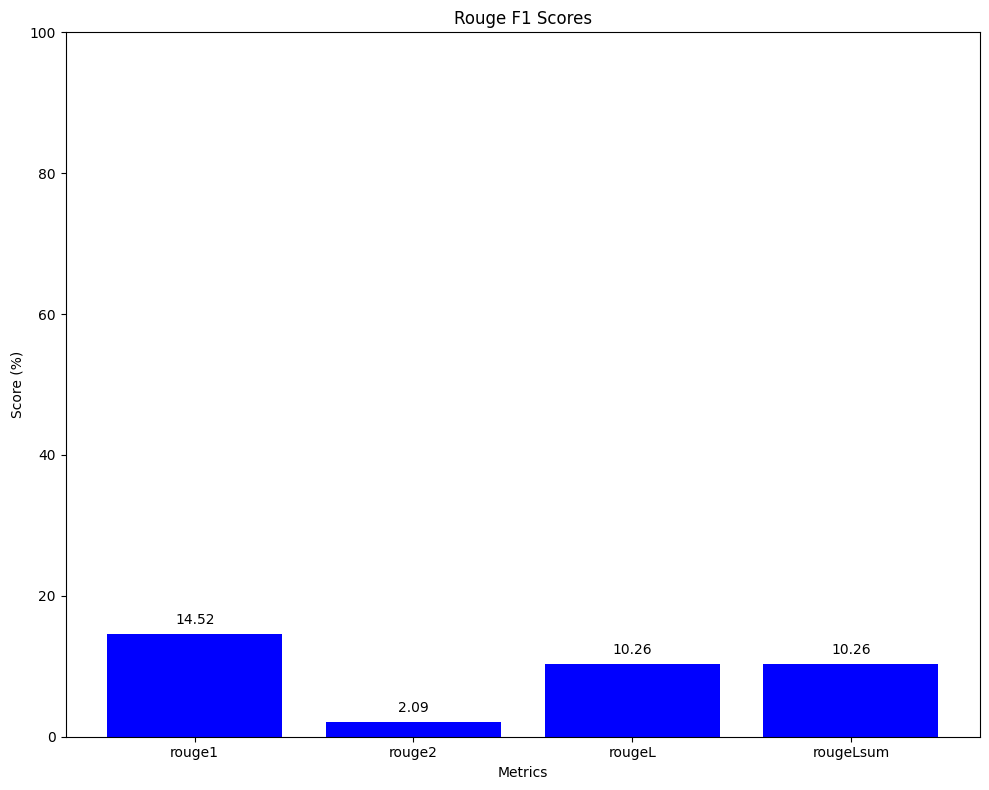

In [34]:
plot_rouge_scores(rouge_result)

Generating a test summary

In [39]:
model.eval()

text = """million from the issuance of 4,419,641 shares of its common stock to third parties to allow gaea to continue to advance its
investment strategy .
we retained a 23.2 % ownership interest in gaea following
the transaction . at december 31 , 2020 we own approximately
23.0 % of gaea and is no longer consolidated in our financial
statements . we elected to be taxed as a reit for u.s. federal
income tax purposes beginning with our taxable year ended december 31 , 2014.
our qualification as a reit depends upon our ability to meet , on a continuing basis ,
various complex requirements under the code relating to , among other things , the sources of our gross income ,
the composition and values of our assets ,
our distribution levels and the diversity of ownership of our capital stock .
we believe that we are organized in conformity with the requirements for qualification as a reit under the code ,
and that our current intended manner of operation enables us to meet the requirements for taxation as a reit for u.s. federal income tax purposes . our portfolio
the following table outlines the carrying value of our portfolio of mortgage loan assets and single-family and smaller commercial properties as of december 31 , 2020
and december 31 , 2019 ( $ in millions ) : replace_table_token_4_th we closely monitor the status of our mortgage loans and,
through our servicer , work with our borrowers to improve their payment records. market trends and outlook covid-19 the covid-19 pandemic that began during the first quarter
of 2020 created a global public-health crisis that resulted in widespread volatility and
deteriorations in household , business
,and economic market conditions , including in the united states ,
where we conduct all of our business . during 2020 many governmental and nongovernmental
authorities directed their actions toward curtailing household and business activity in order to contain
or mitigate the impact of the covid-19 pandemic and deployed fiscal- and monetary-policy measures in order
to seek to partially mitigate the adverse effects . these programs have had varying degrees of success and the extent of the long term impact on the mortgage market remains unknown . the covid-19 pandemic began to meaningfully impact our
operations in late march 2020 and this disruption was
reflected in our results of operations for the quarter
ended march 31 , 2020. since then many of these negative impacts have improved throughout 2020 , as follows
: we recorded net recovery of credit loss provisions of $ 10.8 million on our mortgage loan portfolio and investments in
beneficial interests during the year ended december 31 , 2020. we recorded total expense of $ 5.1 million for provision for anticipated credit
losses on our mortgage loan portfolio and investments in beneficial interests during the three months ended march 31 , 2020 , as a result of expectations of extended portfolio durations and longer foreclosure and eviction
timelines . however , during the remainder of 2020 we recovered $ 15.9 million in credit loss provisions on 47 these portfolios which was
as a result of better than expected loan performance and the related positive impact
on future repayments . we recorded a net $ 0.9 million of unrealized losses on our investments in debt securities
to other comprehensive income during the year ended december 31 , 2020. we recorded $ 28.4 million in unrealized losses on our
investments in debt securities to other comprehensive income for the three months ended march 31 , 2020. however , during
the remainder of 2020 we recovered $ 27.5 million of those unrealized losses . during the course of the year , we
settled net margin calls in the amount of $ 0.5 million with our repurchase financing counterparties during the year ended december 31 , 2020. for the three months ended march 31 ,
2020 we settled $ 28.2 million of net margins calls with our repurchase financing counterparties
due to the extreme disruption in the residential mortgage securities market from the covid-19 pandemic , and since then have recovered $ 27.7 million of cash deposits on a net basis from our repurchase financing counterparties as collateral prices rebounded off the march 31 , 2020 levels .
the pandemic has continued and continues to significantly and adversely impact certain areas of the united states . as a result , our forecast of macroeconomic conditions and expected lifetime credit losses on our mortgage loan and beneficial interest portfolios is subject to meaningful uncertainty . while substantially all of our borrowers continue to make scheduled payments and we continue to receive payments in full , we have acted swiftly to support our borrowers with a mortgage forbearance program . while we generally do not hold loans guaranteed by gses or the us government , we , through our servicer , are nonetheless offering a forbearance program under terms similar to those required for gse loans . borrowers that are able to provide documentation of a negative impact of covid-19 are entitled to three months of forbearance . the three monthly payments may then be repaid over 12 months . if a borrower can not repay the deferred amount , our servicer will work with them on repayment options . notwithstanding the foregoing , to the extent special rules apply to a mortgagor because of the jurisdiction or type of the mortgage loan , the servicer will comply with those rules . our servicer has extensive experience dealing with delinquent borrowers and we believe it is well positioned to react on our behalf to any increase in mortgage delinquencies . story_separator_special_tag conversely , decreases in interest rates , in general , may over time cause : ( a ) prepayments on our mortgage loan and mbs portfolio to increase , thereby accelerating the accretion of our purchase discounts ; ( b ) the value of our mortgage loan and mbs portfolio to increase ; ( c ) coupons on our arm and hybrid arm mortgage loans and mbs to reset , although on a delayed basis , to lower interest rates ; ( d ) the interest expense associated with our borrowings to decrease ; and ( e ) to the extent we enter into interest rate swap agreements as part of our hedging strategy , the value of these agreements to decrease . we currently expect the pace of loan prepayments to slow due to the covid-19 outbreak . market conditions . due to the dramatic repricing of real estate assets that occurred during the 2008 financial crisis and the continuing uncertainty regarding the direction and strength of the real estate markets including as a result of the pandemic , we believe a void in the debt and equity capital available for investing in real estate exists as many financial institutions , insurance companies , finance companies and fund managers have determined to reduce or discontinue investment in debt or equity related to real estate . we believe the dislocations in the residential real estate market have resulted or will result in an “ over-correction ” in the repricing of real estate assets , creating a potential opportunity for us to capitalize on these market dislocations and capital void to the extent we are able to obtain financing for additional purchases . we believe that in spite of the continuing uncertain market environment for mortgage-related assets , including as a result of the pandemic outbreak , current market conditions offer potentially attractive investment opportunities for us , even in the face of a riskier and more volatile market environment . we expect that market conditions will continue to impact our operating results and will cause us to adjust our investment and financing strategies over time as new opportunities emerge and risk profiles of our business change . covid-19 pandemic . the pandemic has also impacted , and is likely to continue to impact , directly or indirectly , many of the other factors discussed above , as well as other aspects of our business . new developments continue to emerge and it is not possible for us to predict with certainty which factors will impact our business . in addition , we can not assess the impact of each factor on our business or the extent to which any factor , or combination of factors , may cause actual results to differ materially from those contained in any forward-looking statements . in particular , it is difficult to fully assess the impact of the pandemic at this time due to , among other things , uncertainty regarding the severity and duration of the outbreak domestically and internationally and the effectiveness of federal , state and local government efforts to contain the spread of covid-19 , the effects of those efforts on our business , the indirect impact on the u.s. economy and economic activity and the impact on the mortgage markets and capital markets . critical accounting policies and estimates certain of our critical accounting policies require management to make estimates and assumptions
that affect the reported amounts of assets and liabilities at the date of the consolidated financial statements and the reported amounts of revenues and expenses during the reporting period . actual results could differ from those estimates . we consider significant estimates to include expected cash flows from mortgage loans and fair value measurements . we believe that all of the decisions 51 and assessments upon which our consolidated financial statements are and will be based were or will be reasonable at the time made based upon information available to us at that time . we have identified our most critical accounting policies to be the accounting policies associated with our mortgage-related assets and our borrowings . mortgage loans purchased credit deteriorated loans ( `` pcd loans `` ) — as of their acquisition date , the loans we acquired have generally suffered some credit deterioration subsequent to origination . as a result , prior to the adoption of asu 2016-13 , financial instruments - credit losses , otherwise known as cecl , on january 1 , 2020 , we were required to account for the mortgage loans pursuant to asc 310-30 , accounting for loans with deterioration in credit quality . under both standards , our recognition of interest income for pcd loans is based upon our having a reasonable expectation of the amount and timing of the cash flows expected to be collected . when the timing and amount of cash flows expected to be collected are reasonably estimable , we use expected cash flows to apply the effective interest method of income recognition . under both cecl and asc 310-30 , acquired loans may be aggregated and accounted for as a pool of loans if the loans have common risk characteristics . a pool is accounted for as a single asset with a single composite interest rate and an aggregate expectation of cash flows . however , cecl allows more flexibility to us to adjust its loan pools as the underlying risk factors change over time . under asc 310-30 , rpls were determined by us to have common risk characteristics and were accounted for as a single loan pool for loans acquired within each three-month calendar quarter . similarly , npls were determined to have common risk characteristics and were accounted for as a single non-performing pool for loans acquired within each three-month calendar quarter . the result was generally two additional pools ( rpls and npls ) each quarter . under cecl , we have re-aggregated our loan pools around similar risk
"""

with torch.no_grad():
    input = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    summary_id = model.generate(**input, max_new_tokens=512)

print(tokenizer.decode(summary_id[0], skip_special_tokens=True))

results of operations the following table sets forth our results of operations for the periods indicated ( in thousands ) : replace_table_token_5_th the following table sets forth our results of operations for the periods indicated ( in thousands ) : replace_table_token_6_th the following table sets forth our results of operations for the periods indicated ( in thousands ) : replace_table_token_7_th the following table sets forth our results of operations for the periods indicated ( in thousands ) : replace_table_token_8_th the following table sets forth our results of operations for the periods indicated ( in thousands ) : replace_table_token_9_th the following table sets forth our results of operations for the periods indicated ( in thousands ) : replace_table_token_10_th the following table sets forth our results of operations for the periods indicated ( in thousands ) : replace_table_token_11_th the following table sets forth our results of operations for the periods indicated ( in